# **Lab3**

## Download data

In [1]:
import requests
import os

dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
filename = "autos_data.csv"

if not filename in os.listdir():
  response = requests.get(dataset_url)
  with open(filename, 'wb') as file:
    file.write(response.content)
  print(filename + " downloaded")
else:
  print(filename + " already exist")

autos_data.csv downloaded


## Create dataframe

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(filename, header=0, skip_blank_lines=True, names=["symboling", "normalized-losses", "make", "fuel-type", "aspiration", "num-of-doors", "body-style", "drive-wheels", "engine-location", "wheel-base", "length", "width", "height", "curb-weight", "engine-type", "num-of-cylinders", "engine-size", "fuel-system", "bore", "stroke", "compression-ratio", "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"])
arr = np.genfromtxt(filename, delimiter=',', dtype=None, encoding='utf-8', names=["symboling", "normalized-losses", "make", "fuel-type", "aspiration", "num-of-doors", "body-style", "drive-wheels", "engine-location", "wheel-base", "length", "width", "height", "curb-weight", "engine-type", "num-of-cylinders", "engine-size", "fuel-system", "bore", "stroke", "compression-ratio", "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"])

df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


## Replace missing data

In [3]:
def df_replace_nan():
  for (col_name, col) in df.iteritems():
    if '?' in list(col):
      numeric = pd.to_numeric(df[col_name], errors='coerce')
      mean_val = np.mean(numeric)
      if not np.isnan(mean_val):
        df[col_name] = numeric
        df[col_name].replace(np.nan, mean_val, inplace=True)
      df[col_name].replace('?', mean_val, inplace=True)
  df.fillna(df.mode().iloc[0], inplace=True)

def arr_replace_nan():
  for col_name in arr.dtype.names:
    col = arr[col_name]
    if '?' in col:
      numeric = pd.to_numeric(col, errors='coerce')
      mean_val = np.nanmean(numeric)
      if np.isnan(mean_val):
        unique, pos = np.unique(col, return_inverse=True)
        counts = np.bincount(pos)
        maxpos = counts.argmax()
        mean_val = unique[maxpos]
        arr[col_name] = np.where(col=='?', mean_val, col)
      else:
        arr[col_name] = numeric
        arr[col_name].astype(np.float, copy=False)
        arr[col_name] = np.where(col==np.nan, mean_val, col)

%timeit df_replace_nan()
%timeit arr_replace_nan()
arr = df.to_numpy()

df.head()

100 loops, best of 3: 19.1 ms per loop


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


The slowest run took 8.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.09 ms per loop


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
1,1,122.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
2,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
3,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
4,2,122.0,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0


## Norm / Standart / Onehot data

In [4]:
norm_map = {
    "symboling": "standartization", "normalized-losses": "normalization", "make": "onehot", "fuel-type": "onehot", 
    "aspiration": "onehot", "num-of-doors": "onehot", "body-style": "onehot", "drive-wheels": "onehot", 
    "engine-location": "onehot", "wheel-base": "standartization", "length": "standartization", "width": "standartization", 
    "height": "standartization", "curb-weight": "standartization", "engine-type": "onehot", "num-of-cylinders": "onehot", 
    "engine-size": "normalization", "fuel-system": "onehot", "bore": "standartization", "stroke": "standartization", 
    "compression-ratio": "normalization", "horsepower": "normalization", "peak-rpm": "standartization", "city-mpg": "standartization", 
    "highway-mpg": "standartization", "price": "normalization"
}

def df_norm_standart_onehot(dataframe):
  result = dataframe.copy()
  for feature_name in dataframe.columns:
    if norm_map[feature_name] == "normalization":
      max_value = dataframe[feature_name].max()
      min_value = dataframe[feature_name].min()
      result[feature_name] = (dataframe[feature_name] - min_value) / (max_value - min_value)
    if norm_map[feature_name] == "standartization":
      mean_value = dataframe[feature_name].mean()
      std_value = dataframe[feature_name].std()
      result[feature_name] = (dataframe[feature_name] - mean_value) / std_value
    if norm_map[feature_name] == "onehot":
      dummies = pd.get_dummies(dataframe[[feature_name]])
      result = pd.concat([result, dummies], axis=1)
      result = result.drop([feature_name], axis=1)
  return result

def arr_norm_standart_onehot(array):
  result = np.copy(array)
  for i, feature_name in enumerate(norm_map.keys()):
    if norm_map[feature_name] == "normalization":
      max_value = array[:, i].max()
      min_value = array[:, i].min()
      result[:, i] = (array[:, i] - min_value) / (max_value - min_value)
    if norm_map[feature_name] == "standartization":
      mean_value = array[:, i].mean()
      std_value = array[:, i].std()
      result[:, i] = (array[:, i] - mean_value) / std_value
    if norm_map[feature_name] == "onehot":
      dummies = pd.get_dummies(array[:, i]).to_numpy()
      result = np.hstack((result, dummies))
      # result = result.drop([feature_name], axis=1)
      # np.delete(e, [1,3], axis=1)
  return result

%timeit df_norm_standart_onehot(df)
%timeit arr_norm_standart_onehot(arr)

norm_df = df_norm_standart_onehot(df)
norm_arr = norm_df.to_numpy()

norm_df.head()

10 loops, best of 3: 81.2 ms per loop
100 loops, best of 3: 11.4 ms per loop


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,make_mercury,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_porsche,make_renault,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,fuel-type_diesel,fuel-type_gas,aspiration_std,aspiration_turbo,num-of-doors_four,num-of-doors_two,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon,drive-wheels_4wd,drive-wheels_fwd,drive-wheels_rwd,engine-location_front,engine-location_rear,engine-type_dohc,engine-type_dohcv,engine-type_l,engine-type_ohc,engine-type_ohcf,engine-type_ohcv,engine-type_rotor,num-of-cylinders_eight,num-of-cylinders_five,num-of-cylinders_four,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,1.756586,0.298429,-1.702724,-0.426707,-0.846254,-2.040916,-0.014566,0.260377,0.519477,-1.855010,0.12500,0.262500,-0.263538,-0.647209,-0.546452,0.282558,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.142426,0.298429,-0.718430,-0.232565,-0.194095,-0.556319,0.512293,0.343396,-2.392100,0.679069,0.12500,0.441667,-0.263538,-0.952482,-0.691414,0.282558,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0.949506,0.518325,0.165766,0.204253,0.131985,0.227218,-0.418811,0.181132,-0.512474,0.454530,0.18750,0.225000,0.782331,-0.189299,-0.111564,0.219254,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0.949506,0.518325,0.099035,0.204253,0.225150,0.227218,0.514209,0.283019,-0.512474,0.454530,0.06250,0.279167,0.782331,-1.105118,-1.271264,0.306142,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.949506,0.298429,0.165766,0.260878,0.178567,-0.267648,-0.093116,0.283019,-0.512474,0.454530,0.09375,0.258333,0.782331,-0.952482,-0.836377,0.251527,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


## Show histograms

symboling


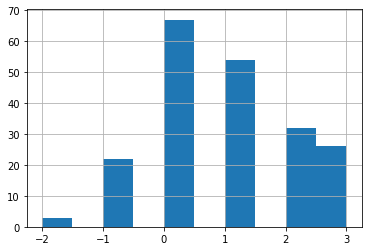

normalized-losses


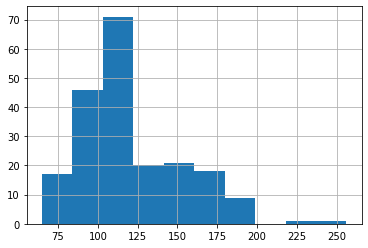

make


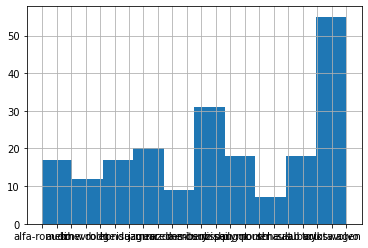

fuel-type


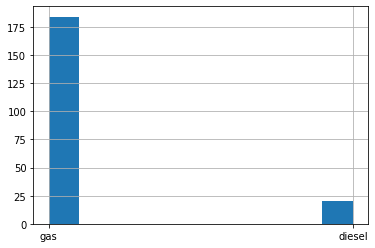

aspiration


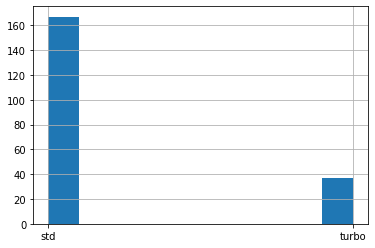

num-of-doors


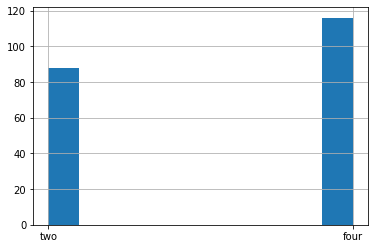

body-style


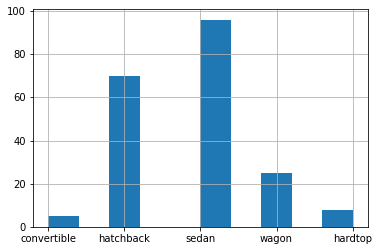

drive-wheels


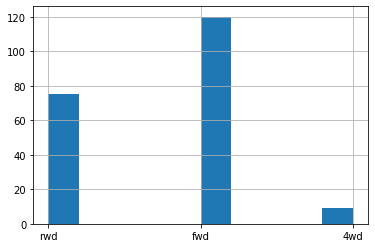

engine-location


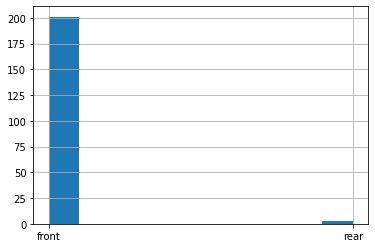

wheel-base


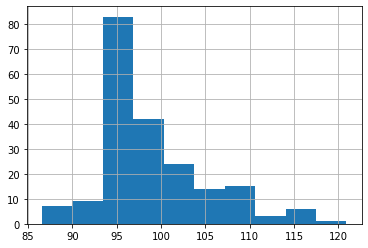

length


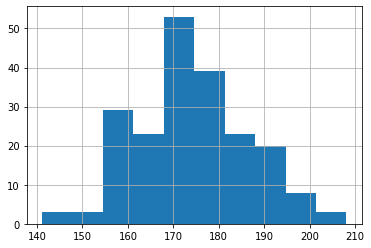

width


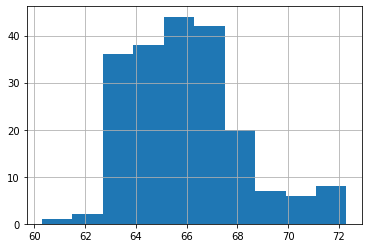

height


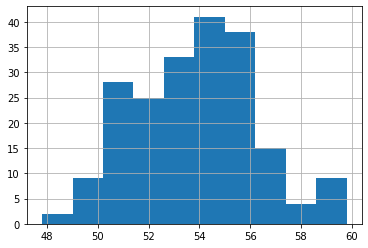

curb-weight


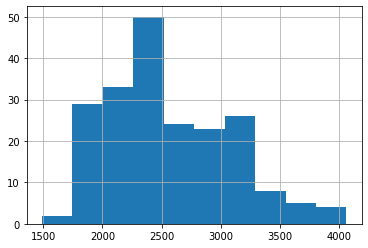

engine-type


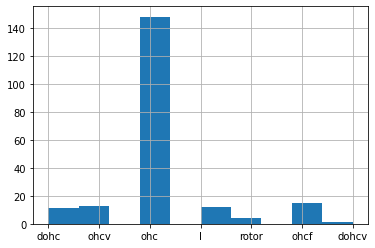

num-of-cylinders


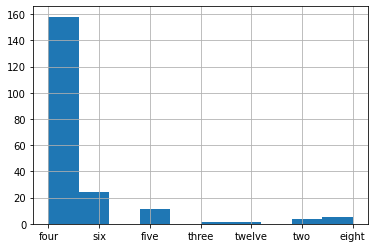

engine-size


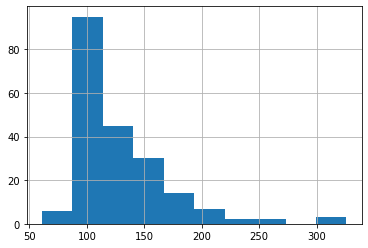

fuel-system


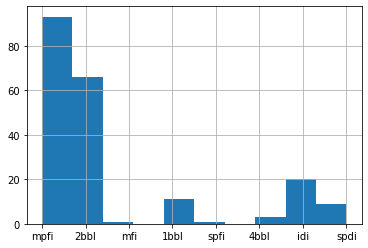

bore


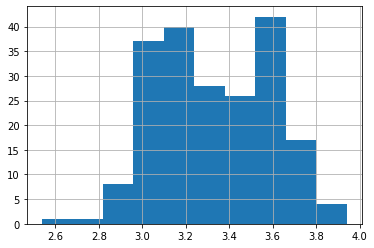

stroke


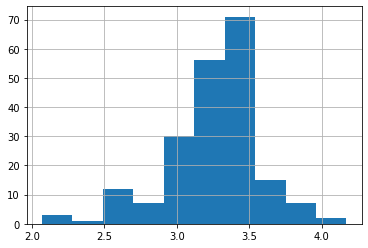

compression-ratio


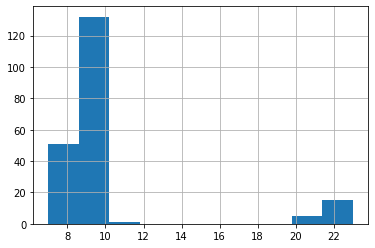

horsepower


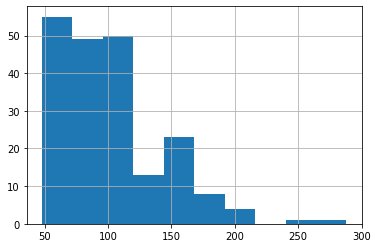

peak-rpm


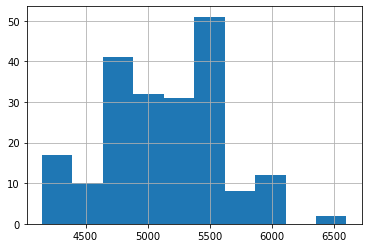

city-mpg


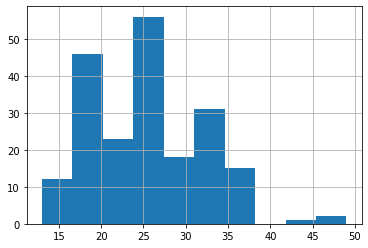

highway-mpg


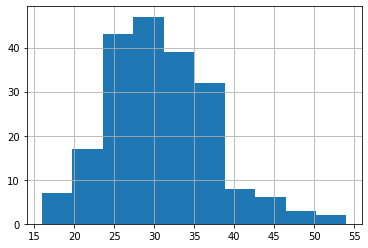

price


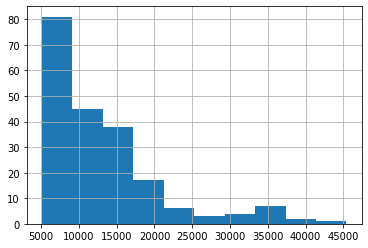

manual price histogram


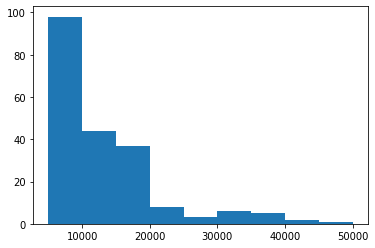

In [5]:
import matplotlib.pyplot as plt

for col_name in df.columns.values:
  print(col_name)
  df[col_name].hist()
  plt.show()

print("manual price histogram")
plt.hist(arr[:, -1], bins = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]) 
plt.show()

## Show how three columns depend on each other

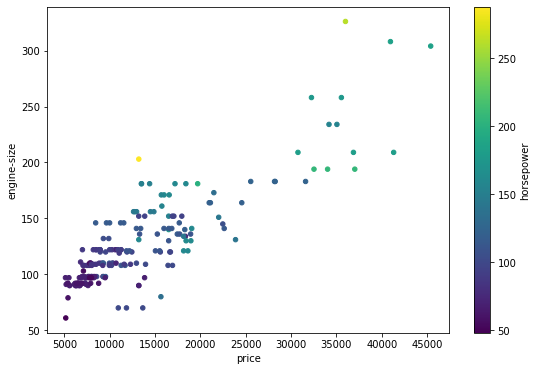

In [6]:
fig, ax1 = plt.subplots()
ax1_plot = df.plot.scatter(x='price', y='engine-size', c='horsepower', colormap='viridis', ax=ax1, figsize=(9, 6))

# plt.show()
# plt.scatter(arr[:, -1], arr[:, 16])
# plt.show()

## Show correlations

In [7]:
%timeit df.corr(method='pearson')
%timeit np.corrcoef(norm_arr)

corr = df.corr(method='pearson')
corr

The slowest run took 6.41 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 562 µs per loop
1000 loops, best of 3: 921 µs per loop


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
symboling,1.000000,0.468695,-0.525095,-0.356792,-0.227799,-0.533078,-0.229281,-0.107229,-0.135712,0.007463,-0.177413,0.070457,0.278059,-0.030557,0.039598,-0.083136
normalized-losses,0.468695,1.000000,-0.056919,0.019217,0.084342,-0.374472,0.097785,0.110998,-0.029330,0.055551,-0.114548,0.203449,0.237788,-0.218973,-0.178351,0.133999
wheel-base,-0.525095,-0.056919,1.000000,0.877612,0.795115,0.582603,0.781763,0.573989,0.496912,0.147856,0.249199,0.355907,-0.365525,-0.479633,-0.552897,0.587607
length,-0.356792,0.019217,0.877612,1.000000,0.841199,0.491969,0.878090,0.683830,0.608241,0.126713,0.157913,0.555076,-0.287753,-0.673251,-0.706635,0.683372
width,-0.227799,0.084342,0.795115,0.841199,1.000000,0.274075,0.868493,0.737042,0.562663,0.177086,0.180287,0.644075,-0.221372,-0.647177,-0.681169,0.730130
height,-0.533078,-0.374472,0.582603,0.491969,0.274075,1.000000,0.298429,0.068577,0.178237,-0.075251,0.261036,-0.109549,-0.326555,-0.055659,-0.113995,0.136123
curb-weight,-0.229281,0.097785,0.781763,0.878090,0.868493,0.298429,1.000000,0.850611,0.648965,0.170018,0.151372,0.751035,-0.266348,-0.758238,-0.798088,0.820831
engine-size,-0.107229,0.110998,0.573989,0.683830,0.737042,0.068577,0.850611,1.000000,0.584069,0.205242,0.029083,0.810718,-0.244547,-0.654101,-0.677775,0.861753
bore,-0.135712,-0.029330,0.496912,0.608241,0.562663,0.178237,0.648965,0.584069,1.000000,-0.051692,0.005949,0.575713,-0.254389,-0.583781,-0.586361,0.532562
stroke,0.007463,0.055551,0.147856,0.126713,0.177086,-0.075251,0.170018,0.205242,-0.051692,1.000000,0.185050,0.090574,-0.069455,-0.048697,-0.049536,0.083115


In [8]:
df.corr(method='spearman')

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
symboling,1.000000,0.482813,-0.532291,-0.395795,-0.250010,-0.516800,-0.261967,-0.182865,-0.177575,-0.007863,0.024115,-0.013338,0.286886,-0.011242,0.059925,-0.151905
normalized-losses,0.482813,1.000000,-0.071584,0.046149,0.117686,-0.350716,0.119110,0.119794,-0.022809,0.100842,-0.065945,0.231909,0.241030,-0.250708,-0.203907,0.203475
wheel-base,-0.532291,-0.071584,1.000000,0.914488,0.812457,0.627933,0.773527,0.657663,0.547161,0.218018,-0.127843,0.510301,-0.317696,-0.502803,-0.548147,0.683955
length,-0.395795,0.046149,0.914488,1.000000,0.887859,0.524951,0.892331,0.785505,0.642378,0.183224,-0.192555,0.665877,-0.271525,-0.673404,-0.701099,0.794104
width,-0.250010,0.117686,0.812457,0.887859,1.000000,0.346796,0.866987,0.774268,0.614404,0.235832,-0.145485,0.696070,-0.201148,-0.692381,-0.705323,0.794881
height,-0.516800,-0.350716,0.627933,0.524951,0.346796,1.000000,0.351001,0.206496,0.223856,-0.030706,-0.000444,0.013003,-0.302287,-0.075624,-0.139215,0.254768
curb-weight,-0.261967,0.119110,0.773527,0.892331,0.866987,0.351001,1.000000,0.877469,0.702573,0.166631,-0.219156,0.807724,-0.236893,-0.813230,-0.834347,0.890797
engine-size,-0.182865,0.119794,0.657663,0.785505,0.774268,0.206496,0.877469,1.000000,0.702424,0.297069,-0.234973,0.819703,-0.273610,-0.729715,-0.720710,0.807532
bore,-0.177575,-0.022809,0.547161,0.642378,0.614404,0.223856,0.702573,0.702424,1.000000,-0.076944,-0.161086,0.640609,-0.298736,-0.608750,-0.614630,0.629559
stroke,-0.007863,0.100842,0.218018,0.183224,0.235832,-0.030706,0.166631,0.297069,-0.076944,1.000000,-0.072523,0.142741,-0.077335,-0.036450,-0.035453,0.107329


## Visualization

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


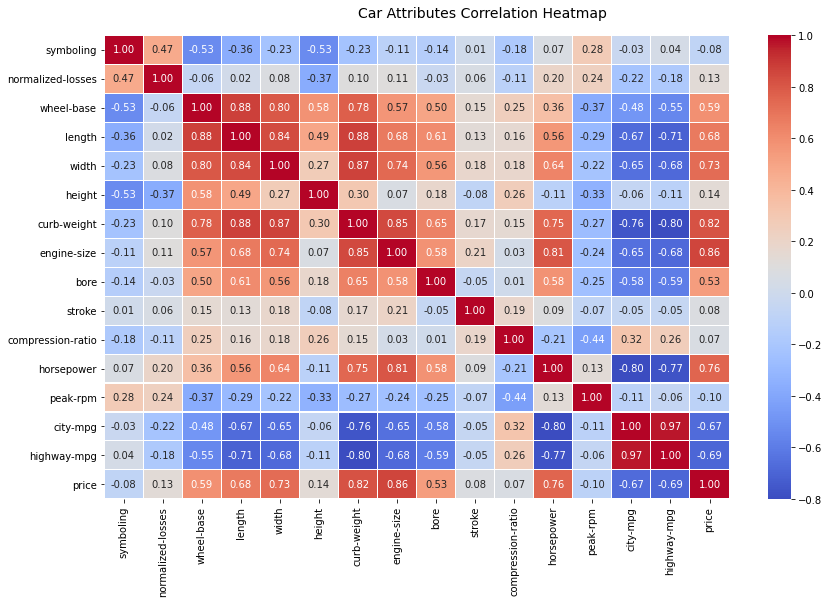

In [9]:
import seaborn as sns

f, ax = plt.subplots(figsize=(14, 8))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm", fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Car Attributes Correlation Heatmap', fontsize=14)

Car Price - Horsepower - Body Style Type


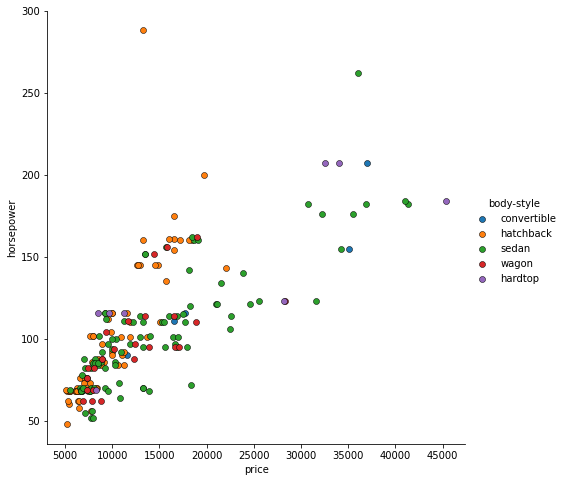

In [10]:
print('Car Price - Horsepower - Body Style Type')
jp = sns.pairplot(df, x_vars=["price"], y_vars=["horsepower"], height=6.5,
                  hue="body-style",
                  plot_kws=dict(edgecolor="k", linewidth=0.5))

Text(0.5, 0, 'Engine Size')

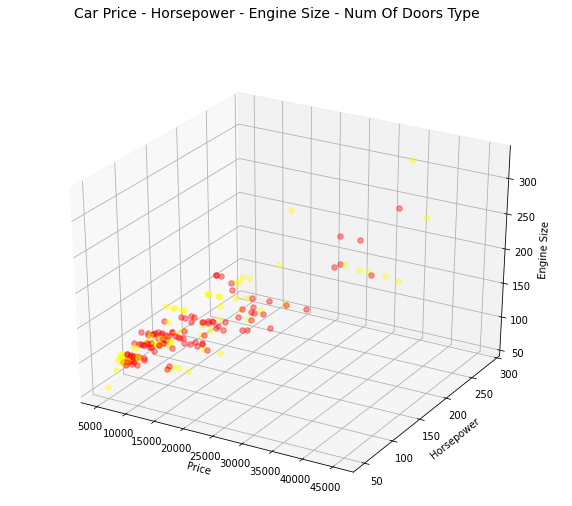

In [11]:
fig = plt.figure(figsize=(10, 8))
t = fig.suptitle('Car Price - Horsepower - Engine Size - Num Of Doors Type', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(df['price'])
ys = list(df['horsepower'])
zs = list(df['engine-size'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['red' if wt == 'four' else 'yellow' for wt in list(df['num-of-doors'])]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, depthshade=False, s=30)

ax.set_xlabel('Price')
ax.set_ylabel('Horsepower')
ax.set_zlabel('Engine Size')

## Train, Val, and Test data

In [12]:
from sklearn.model_selection import train_test_split

X = norm_df[["engine-size", "horsepower"]].to_numpy()
Y = norm_df["price"].to_numpy()
print("X shape: " + str(X.shape))
print("Y shape: " + str(Y.shape))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
print("Training X shape: " + str(x_train.shape))
print("Training Y shape: " + str(y_train.shape))
print("Test X shape: " + str(x_test.shape))
print("Test Y shape: " + str(y_test.shape))

X shape: (204, 2)
Y shape: (204,)
Training X shape: (102, 2)
Training Y shape: (102,)
Test X shape: (102, 2)
Test Y shape: (102,)


## Create models

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# kNN
knn_model = KNeighborsRegressor()

# SVM
svr_model = SVR(kernel='rbf', C=1e3, gamma=0.1)

# RF
rf_model = RandomForestRegressor(n_estimators=10)

# MLP
mlp_model = Sequential()
mlp_model.add(Dense(X.shape[1]))
mlp_model.add(Dense(1))
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Fit models

In [14]:
# kNN
knn_model.fit(x_train, y_train)

# SVM
svr_model.fit(x_train, y_train)

# RF
rf_model.fit(x_train, y_train)

# MLP
history = mlp_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10000, callbacks=[es], batch_size=1, verbose=2)

Epoch 1/10000
102/102 - 0s - loss: 0.0468 - mae: 0.1307 - val_loss: 0.0348 - val_mae: 0.1286
Epoch 2/10000
102/102 - 0s - loss: 0.0276 - mae: 0.1145 - val_loss: 0.0310 - val_mae: 0.1294
Epoch 3/10000
102/102 - 0s - loss: 0.0238 - mae: 0.1132 - val_loss: 0.0281 - val_mae: 0.1253
Epoch 4/10000
102/102 - 0s - loss: 0.0206 - mae: 0.1043 - val_loss: 0.0259 - val_mae: 0.1169
Epoch 5/10000
102/102 - 0s - loss: 0.0185 - mae: 0.1025 - val_loss: 0.0235 - val_mae: 0.1135
Epoch 6/10000
102/102 - 0s - loss: 0.0168 - mae: 0.0962 - val_loss: 0.0218 - val_mae: 0.1068
Epoch 7/10000
102/102 - 0s - loss: 0.0149 - mae: 0.0877 - val_loss: 0.0204 - val_mae: 0.1035
Epoch 8/10000
102/102 - 0s - loss: 0.0136 - mae: 0.0905 - val_loss: 0.0196 - val_mae: 0.0928
Epoch 9/10000
102/102 - 0s - loss: 0.0128 - mae: 0.0821 - val_loss: 0.0185 - val_mae: 0.0927
Epoch 10/10000
102/102 - 0s - loss: 0.0118 - mae: 0.0806 - val_loss: 0.0178 - val_mae: 0.0899
Epoch 11/10000
102/102 - 0s - loss: 0.0113 - mae: 0.0779 - val_loss: 

## Evaluate

kNN Test MSE: 0.013
SVM Test MSE: 0.013
RF Test MSE: 0.010
MLP Test MSE: 0.012


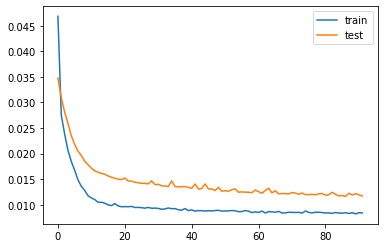

In [15]:
from sklearn.metrics import mean_squared_error

# kNN
pred = knn_model.predict(x_test)
test_mse = mean_squared_error(y_test, pred)
print('kNN Test MSE: %.3f' % ( test_mse))

# SVM
pred = svr_model.predict(x_test)
test_mse = mean_squared_error(y_test, pred)
print('SVM Test MSE: %.3f' % ( test_mse))

# RF
pred = rf_model.predict(x_test)
test_mse = mean_squared_error(y_test, pred)
print('RF Test MSE: %.3f' % ( test_mse))

# MLP
test_mse, test_mae = mlp_model.evaluate(x_test, y_test, verbose=0)
print('MLP Test MSE: %.3f' % (test_mse))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Try to predict using model

In [16]:
sample_data = np.array([[320, 280], 
                        [70, 50], 
                        [121, 112]], dtype=np.float64)

norm_sample_data = np.copy(sample_data)
for i, feature_name in enumerate(["engine-size", "horsepower"]):
  max_value = df[feature_name].max()
  min_value = df[feature_name].min()
  norm_sample_data[:, i] = (sample_data[:, i] - min_value) / (max_value - min_value)
print("Normalized data:\n", norm_sample_data)

pred = np.reshape(rf_model.predict(norm_sample_data), (sample_data.shape[0], 1))
print("\nNormalized price:\n", pred)

max_value = df["price"].max()
min_value = df["price"].min()
pred = (pred * (max_value - min_value)) + min_value
pred_df = pd.DataFrame(np.hstack((sample_data, pred)), columns=["engine-size", "horsepower", "price"])
pred_df

Normalized data:
 [[0.97735849 0.96666667]
 [0.03396226 0.00833333]
 [0.22641509 0.26666667]]

Normalized price:
 [[0.79384837]
 [0.0145421 ]
 [0.2354421 ]]


,engine-size,horsepower,price
0,320.0,280.0,37095.800000
1,70.0,50.0,5703.785000
2,121.0,112.0,14602.078571
